<a href="https://colab.research.google.com/github/antoniRodriguez/computer-vision-pytorch/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-3a5mczi1
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-3a5mczi1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset 

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

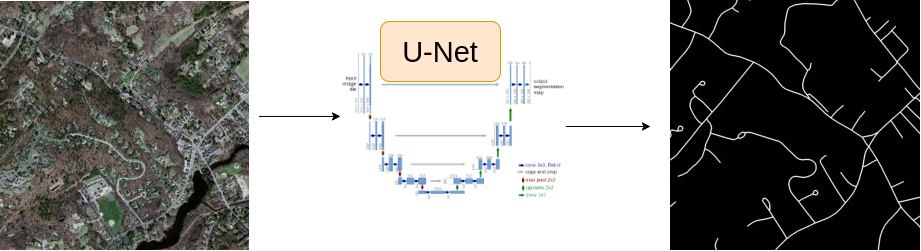

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 15
row = df.iloc[idx]
image_path = DATA_DIR + row.images
mask_path = DATA_DIR + row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255

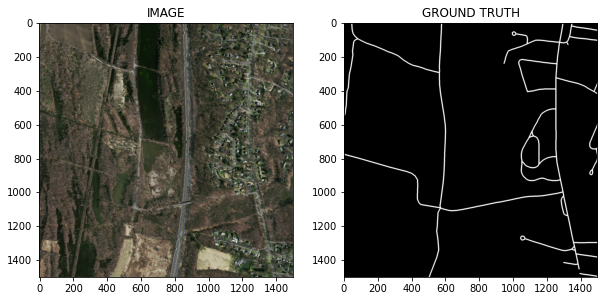

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap='gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])
  
def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
      row = df.iloc[idx]
      image_path = DATA_DIR + row.images
      mask_path = DATA_DIR + row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1) # (h,w,c)

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']
      
      # pytorch uses (c, h, w) -> we need to specify in the transpose indexes
      # originally we have (h,w,c)
      # which can be expressed with indexes:
      #                     0 1 2
      #                     \ \ /
      #                      \ \ 
      #                      /\ \
      #                     (c,h,w)
      # which expressed with indexes:
      #                      2,0,1
      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f'Size of trainset: {len(trainset)}')
print(f'Size of validset: {len(validset)}')

Size of trainset: 159
Size of validset: 40


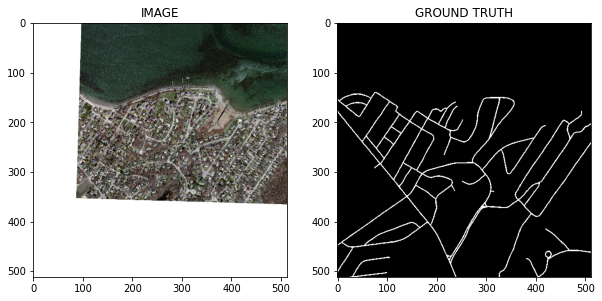

In [ ]:
idx = 58
image, mask = trainset[idx]

helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f'Total number of batches in trainloader: {len(trainloader)}')
print(f'Total number of batches in validloader: {len(validloader)}')

Total number of batches in trainloader: 20
Total number of batches in validloader: 5


In [ ]:
for images, masks in trainloader:
  print(f"One batch image shape: {images.shape}")
  print(f"One batch mask shape: {masks.shape}")
  break

One batch image shape: torch.Size([8, 3, 512, 512])
One batch mask shape: torch.Size([8, 1, 512, 512])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.backbone = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks=None):
    """
    mask is none so that the forward function can be used for testing
    """
    logits = self.backbone(images)
    if masks is not None:
      print('calculating loss')
      return logits, DiceLoss(mode='binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
    
    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

# Task 7 : Create Train and Validation Function 

In [ ]:
def train(dataloader, model, optimizer):
  model.train() # turn on dropout, batchnorm and other needed layers

  total_loss = 0.0

  for images, masks in tqdm(dataloader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # compute gradients
    optimizer.step() # update learning parameters

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [ ]:
def eval(dataloader, model):
  model.eval() # turn off dropout, batchnorm and other needed layers

  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)
      total_loss += loss.item()

  return total_loss / len(dataloader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [ ]:
best_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train(trainloader, model, optimizer)
  valid_loss = eval(validloader, model)

  if valid_loss < best_loss:
    torch.save(model.state_dict(), "bes-model.pt")
    print("SAVED MODEL")
    best_loss = valid_loss
  
  print(f"EPOCH: {i+1} Train Loss: {train_loss} Valid Loss: {valid_loss}")

  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:22,  1.20s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:20,  1.14s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.11s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.12s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.10s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.10s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.10s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


calculating loss
SAVED MODEL
EPOCH: 1 Train Loss: 0.737550912797451 Valid Loss: 0.5498812198638916


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.10s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.10s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.33it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


calculating loss
SAVED MODEL
EPOCH: 2 Train Loss: 0.3711074158549309 Valid Loss: 0.3286186456680298


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.10s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.10s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:15,  1.20s/it]

calculating loss


 40%|████      | 8/20 [00:09<00:15,  1.31s/it]

calculating loss


 45%|████▌     | 9/20 [00:10<00:13,  1.24s/it]

calculating loss


 50%|█████     | 10/20 [00:11<00:11,  1.19s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:10,  1.16s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:09,  1.14s/it]

calculating loss


 65%|██████▌   | 13/20 [00:15<00:07,  1.13s/it]

calculating loss


 70%|███████   | 14/20 [00:16<00:06,  1.12s/it]

calculating loss


 75%|███████▌  | 15/20 [00:17<00:05,  1.11s/it]

calculating loss


 80%|████████  | 16/20 [00:18<00:04,  1.10s/it]

calculating loss


 85%|████████▌ | 17/20 [00:19<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:20<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:21<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.36it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


calculating loss
SAVED MODEL
EPOCH: 3 Train Loss: 0.2332519717514515 Valid Loss: 0.18887586891651154


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.07s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.07s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.07s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.07s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:14,  1.07s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:13,  1.07s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.07s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.07s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:12<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:13<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:03,  1.29it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.32it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

calculating loss


SAVED MODEL
EPOCH: 4 Train Loss: 0.16217925325036048 Valid Loss: 0.15573552250862122


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.32it/s]

calculating loss


 80%|████████  | 4/5 [00:03<00:00,  1.32it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

calculating loss


SAVED MODEL
EPOCH: 5 Train Loss: 0.13293665908277036 Valid Loss: 0.10979210585355759


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.36it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

calculating loss


SAVED MODEL
EPOCH: 6 Train Loss: 0.10648752190172672 Valid Loss: 0.08213286101818085


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.11s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.11s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.10s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.36it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


calculating loss
SAVED MODEL
EPOCH: 7 Train Loss: 0.07435466460883618 Valid Loss: 0.06694431602954865


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.10s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.10s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.10s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.10s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

calculating loss


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

calculating loss


SAVED MODEL
EPOCH: 8 Train Loss: 0.061899769119918346 Valid Loss: 0.05709744989871979


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


calculating loss
EPOCH: 9 Train Loss: 0.05196645800024271 Valid Loss: 0.05767147243022919


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.37it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

calculating loss


SAVED MODEL
EPOCH: 10 Train Loss: 0.04302981160581112 Valid Loss: 0.03206106647849083


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:12<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.34it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


calculating loss
EPOCH: 11 Train Loss: 0.03371014650911093 Valid Loss: 0.03317226842045784


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.34it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.36it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]


calculating loss
SAVED MODEL
EPOCH: 12 Train Loss: 0.03001184668391943 Valid Loss: 0.022782333195209503


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]


calculating loss
EPOCH: 13 Train Loss: 0.027957039885222912 Valid Loss: 0.026674162596464157


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.11s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:13,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.10s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.34it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

calculating loss


SAVED MODEL
EPOCH: 14 Train Loss: 0.025010855868458748 Valid Loss: 0.018290014937520027


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.11s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.10s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.10s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.10s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.10s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.38it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.37it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.37it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

calculating loss


SAVED MODEL
EPOCH: 15 Train Loss: 0.018000143580138683 Valid Loss: 0.01181759126484394


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.10s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.07s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:12<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:03,  1.33it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

calculating loss


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

calculating loss


SAVED MODEL
EPOCH: 16 Train Loss: 0.011717680562287568 Valid Loss: 0.008162406273186207


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.08s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:12,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:12<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]


calculating loss
EPOCH: 17 Train Loss: 0.010820642719045282 Valid Loss: 0.008376210927963257


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.11s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

calculating loss


SAVED MODEL
EPOCH: 18 Train Loss: 0.009882891457527876 Valid Loss: 0.006317943334579468


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.10s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.10s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.10s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.10s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.10s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.10s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.33it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

calculating loss


 80%|████████  | 4/5 [00:03<00:00,  1.33it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.33it/s]

calculating loss


SAVED MODEL
EPOCH: 19 Train Loss: 0.006646557454951107 Valid Loss: 0.005152133293449879


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.10s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:11,  1.11s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.11s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.10s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.10s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.10s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.10s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

calculating loss


SAVED MODEL
EPOCH: 20 Train Loss: 0.006656781397759914 Valid Loss: 0.004141476936638355


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.11s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.10s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.11s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.10s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.10s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:12,  1.10s/it]

calculating loss


 50%|█████     | 10/20 [00:11<00:10,  1.10s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.10s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.10s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.10s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

calculating loss


SAVED MODEL
EPOCH: 21 Train Loss: 0.004450141557026654 Valid Loss: 0.0036569072399288416


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.09s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.36it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.36it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.35it/s]

calculating loss


SAVED MODEL
EPOCH: 22 Train Loss: 0.00468420775141567 Valid Loss: 0.0028014511335641146


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.08s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.08s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.08s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.08s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.08s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.38it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.31it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.33it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.33it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

calculating loss


SAVED MODEL
EPOCH: 23 Train Loss: 0.004271937161684036 Valid Loss: 0.0026417614426463842


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:21,  1.12s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.10s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.09s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.09s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.09s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.09s/it]

calculating loss


 55%|█████▌    | 11/20 [00:12<00:09,  1.09s/it]

calculating loss


 60%|██████    | 12/20 [00:13<00:08,  1.09s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.09s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.09s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.09s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.09s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.09s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.10s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.09s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.35it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.34it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.34it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.34it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]

calculating loss


SAVED MODEL
EPOCH: 24 Train Loss: 0.003407373942900449 Valid Loss: 0.002004858572036028


  0%|          | 0/20 [00:00<?, ?it/s]

calculating loss


  5%|▌         | 1/20 [00:01<00:20,  1.09s/it]

calculating loss


 10%|█         | 2/20 [00:02<00:19,  1.09s/it]

calculating loss


 15%|█▌        | 3/20 [00:03<00:18,  1.08s/it]

calculating loss


 20%|██        | 4/20 [00:04<00:17,  1.09s/it]

calculating loss


 25%|██▌       | 5/20 [00:05<00:16,  1.09s/it]

calculating loss


 30%|███       | 6/20 [00:06<00:15,  1.09s/it]

calculating loss


 35%|███▌      | 7/20 [00:07<00:14,  1.09s/it]

calculating loss


 40%|████      | 8/20 [00:08<00:13,  1.08s/it]

calculating loss


 45%|████▌     | 9/20 [00:09<00:11,  1.08s/it]

calculating loss


 50%|█████     | 10/20 [00:10<00:10,  1.08s/it]

calculating loss


 55%|█████▌    | 11/20 [00:11<00:09,  1.08s/it]

calculating loss


 60%|██████    | 12/20 [00:12<00:08,  1.08s/it]

calculating loss


 65%|██████▌   | 13/20 [00:14<00:07,  1.08s/it]

calculating loss


 70%|███████   | 14/20 [00:15<00:06,  1.08s/it]

calculating loss


 75%|███████▌  | 15/20 [00:16<00:05,  1.08s/it]

calculating loss


 80%|████████  | 16/20 [00:17<00:04,  1.08s/it]

calculating loss


 85%|████████▌ | 17/20 [00:18<00:03,  1.08s/it]

calculating loss


 90%|█████████ | 18/20 [00:19<00:02,  1.08s/it]

calculating loss


 95%|█████████▌| 19/20 [00:20<00:01,  1.08s/it]

calculating loss


 20%|██        | 1/5 [00:00<00:02,  1.34it/s]

calculating loss


 40%|████      | 2/5 [00:01<00:02,  1.35it/s]

calculating loss


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

calculating loss


 80%|████████  | 4/5 [00:02<00:00,  1.35it/s]

calculating loss


100%|██████████| 5/5 [00:03<00:00,  1.36it/s]

calculating loss
SAVED MODEL
EPOCH: 25 Train Loss: 0.002531014010310173 Valid Loss: 0.001613666070625186


# Task 9 : Inference

In [ ]:
idx = 2

model.load_state_dict(torch.load('/content/bes-model.pt'))
image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) # add batch dim. (b,c,h,w)

pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

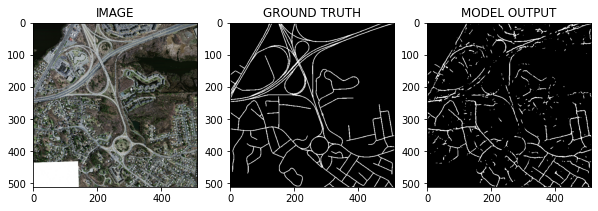

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

